# 数据总体概况

## 数据形状

In [36]:
import pandas as pd

xlsx_path = "../data/anonymized_data_for_workshop.xlsx"
xlsx_sheet_name = "SQL Results"
pkl_path = "../data/data_raw.pkl"

# 读取数据
# 从 Excel 文件读取太慢。首次读取后将数据保存为 pickle 格式。
try:
    df: pd.DataFrame = pd.read_pickle(pkl_path)
except FileNotFoundError:
    try:
        df = pd.read_excel(xlsx_path, sheet_name=xlsx_sheet_name)
        df.to_pickle(pkl_path)
    except:
        print(
            "未能读取数据。请将 anonymized_data_for_workshop.xlsx 文件复制到 data 目录下"
        )
        raise
df

,,HIS出院科室,住院号码,病床号,病人姓名,入院时间,出院时间,采集时间,钾,钠,...,白介素8,白介素8 1,白介素10,白介素10 1,白介素17A,白介素17A 1,肿瘤坏死因子α,肿瘤坏死因子α 1,干扰素γ,干扰素γ 1
0,1,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-20 19:38:19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:26,3.93,132.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,内分泌代谢科,372320,2007,cai hui bin,2022-01-20 18:41:00,2022-01-26 09:07:00,2022-01-21 05:35:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27346,27353,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:52,3.92,143.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27347,27354,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:25:58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27348,27355,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27349,27356,日间病房,463319,6B08,JESSIE MINHUA CHEN,2024-05-30 09:39:00,2024-05-31 13:46:00,2024-05-30 10:45:53,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27351 entries, 0 to 27350
Columns: 110 entries,     to 干扰素γ 1
dtypes: datetime64[ns](3), float64(49), int64(2), object(56)
memory usage: 23.0+ MB


数据总共27351行，110列。

## 空值检测

### 检查全空的行和列

In [31]:
# 检查全空的列
empty_columns = df.columns[df.isnull().all()]
print(f"全空的列（共{len(empty_columns)}个）:", empty_columns.tolist())

# 检查除了前八列以外的全空的行
empty_rows = df.index[df.iloc[:, 8:].isnull().all(axis=1)]
print(f"没有任何检测结果的行（共{len(empty_rows)}个）:", empty_rows.tolist())

# 删除全空的列和行
df.drop(columns=empty_columns, inplace=True)
df.drop(index=empty_rows, inplace=True)

# 保存为 pickle 格式
df.to_pickle("../data/data_remove_empty.pkl")

df_backup = df.copy()

全空的列（共14个）: ['促甲状腺素受体抗体1', '甲状腺球蛋白抗体', '骨源碱性磷酸酶1', '甲状旁腺激素（pg/ml）', '甘油三酯', '雌二醇(30分钟）', '雌二醇(60分钟）', '雌二醇(90分钟）', '促卵泡成熟素（30分钟）', '促卵泡成熟素（60分钟）', '促卵泡成熟素（90分钟）', '促黄体生成素（30分钟）', '促黄体生成素（60分钟）', '促黄体生成素（90分钟）']
没有任何检测结果的行（共1个）: [4679]


全空的行和列对于数据分析没有意义，我们直接在这一步将其删除。

### 检查剩余的空值

In [32]:
examine_results = df.iloc[:, 8:]
empty_cnt = examine_results.isnull().sum().sum()
n_columns = len(examine_results.columns)
n_rows = len(examine_results.index)
print(f"除开个人信息、入院出院时间等，检查结果共有 {n_rows} 行，{n_columns} 列")
print(f"其中有 {empty_cnt} 个空值，空值比例为 {empty_cnt / (n_rows * n_columns):.2%}")
# # 计算每列的空值比例
# empty_ratio = examine_results.isnull().sum() / n_rows
# print("每列的空值比例：")
# print(empty_ratio.sort_values(ascending=False))

除开个人信息、入院出院时间等，检查结果共有 27350 行，88 列
其中有 2243960 个空值，空值比例为 93.23%


空缺的数据太过于多，以至于我们不太可能统一填补所有空值才做后续处理。数据的稀疏性可能是本项目要面对的挑战之一。

## 特殊值

可能是受限于检测仪器的量程，部分值带有小于号、大于号和问号，例如：

In [33]:
print("部分值包含特殊符号，例如：")
print(df.loc[26698, "雌二醇"])
print(df.loc[26698, "叶酸"])
print(df.loc[22937, "葡萄糖"])

# 统计特殊符号出现的次数
special_symbols = ['<', '>', '?']
special_counts = {
    symbol: examine_results.astype(str)
    .apply(lambda col: col.str.contains(symbol, regex=False))
    .sum()
    .sum()
    for symbol in special_symbols
}

print("特殊符号出现的次数：")
for symbol, count in special_counts.items():
    print(f"{symbol}: {count} 次, 占比 {count / empty_cnt:.2%}")

部分值包含特殊符号，例如：
<43.6
>54.36
?13.2
特殊符号出现的次数：
<: 3644 次, 占比 0.16%
>: 357 次, 占比 0.02%
?: 2 次, 占比 0.00%


## 时间维度分析

数据有出院时间和入院时间，每一次出入院对应一个住院号码，我们可以统计一下，出入院的人数和时间的关系。

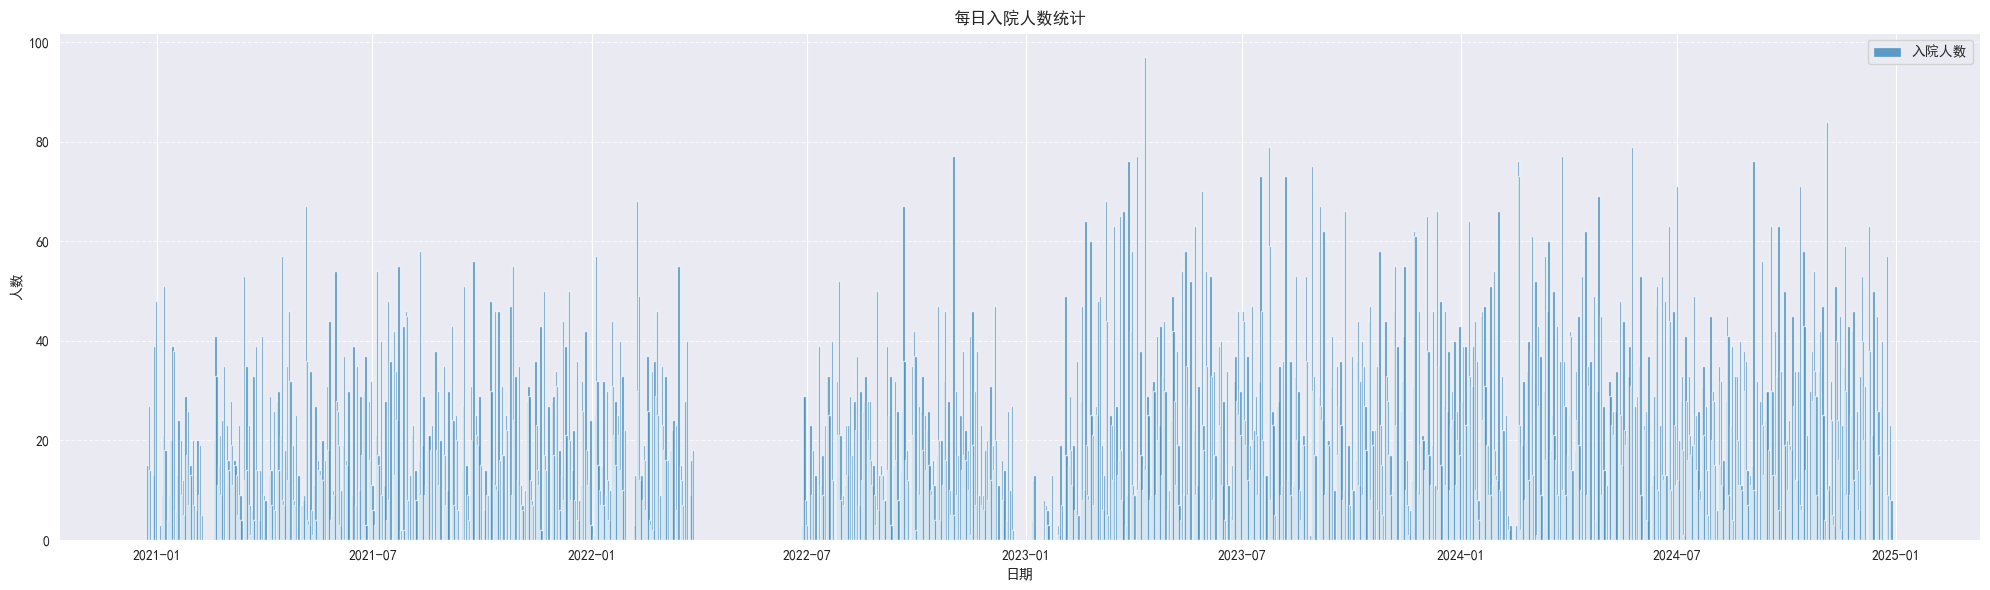

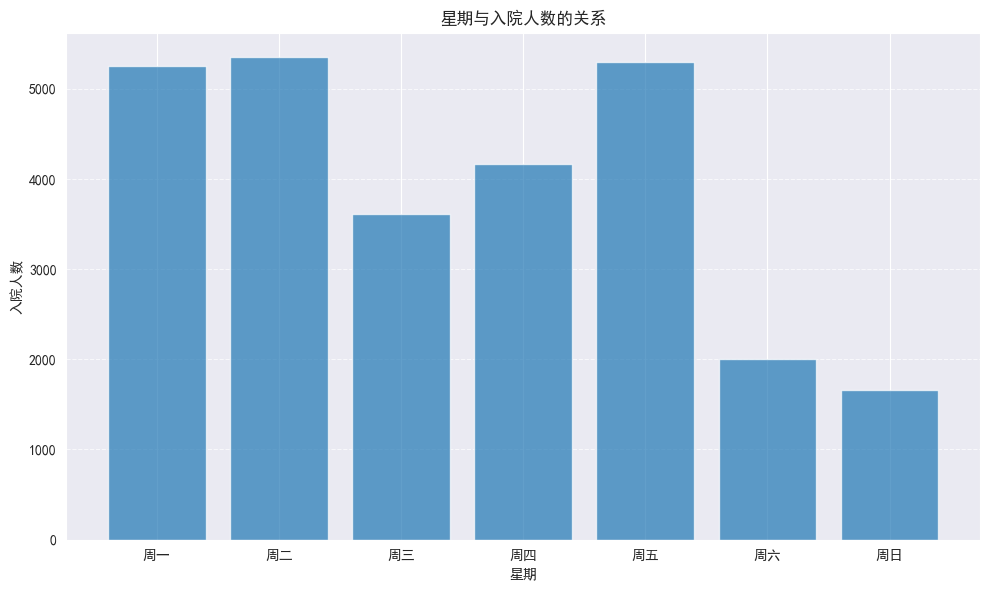

In [34]:
import matplotlib.pyplot as plt

# 将入院时间和出院时间转换为日
df['入院日'] = pd.to_datetime(df['入院时间']).dt.to_period('D').apply(lambda r: r.start_time)
df['出院日'] = pd.to_datetime(df['出院时间']).dt.to_period('D').apply(lambda r: r.start_time)

# 按周统计入院和出院人数
weekly_admissions = df.groupby('入院日').size()
weekly_discharges = df.groupby('出院日').size()
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体
# 绘制条形图
plt.figure(figsize=(20, 6))
plt.bar(weekly_admissions.index, weekly_admissions.values, width=2, label='入院人数', alpha=0.7)
plt.xlabel('日期')
plt.ylabel('人数')
plt.title('每日入院人数统计')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 统计每个星期几的入院人数
df['入院星期'] = df['入院日'].dt.dayofweek  # 0: Monday, 6: Sunday
weekday_admissions = df.groupby('入院星期').size()

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(weekday_admissions.index, weekday_admissions.values, alpha=0.7)
plt.xlabel('星期')
plt.xticks(ticks=weekday_admissions.index, labels=['周一', '周二', '周三', '周四', '周五', '周六', '周日'])
plt.ylabel('入院人数')
plt.title('星期与入院人数的关系')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

从日期的可视化可以看出：
- 每年农历新年时，入院人数减少。
- 疫情封控期间 和 疫情放开初期 ，出现连续多日入院人数为0的情况。

从星期的可视化可以看出：
- 周六周日的入院人数较少。这可能与患者的习惯或者医院的工作安排有关。

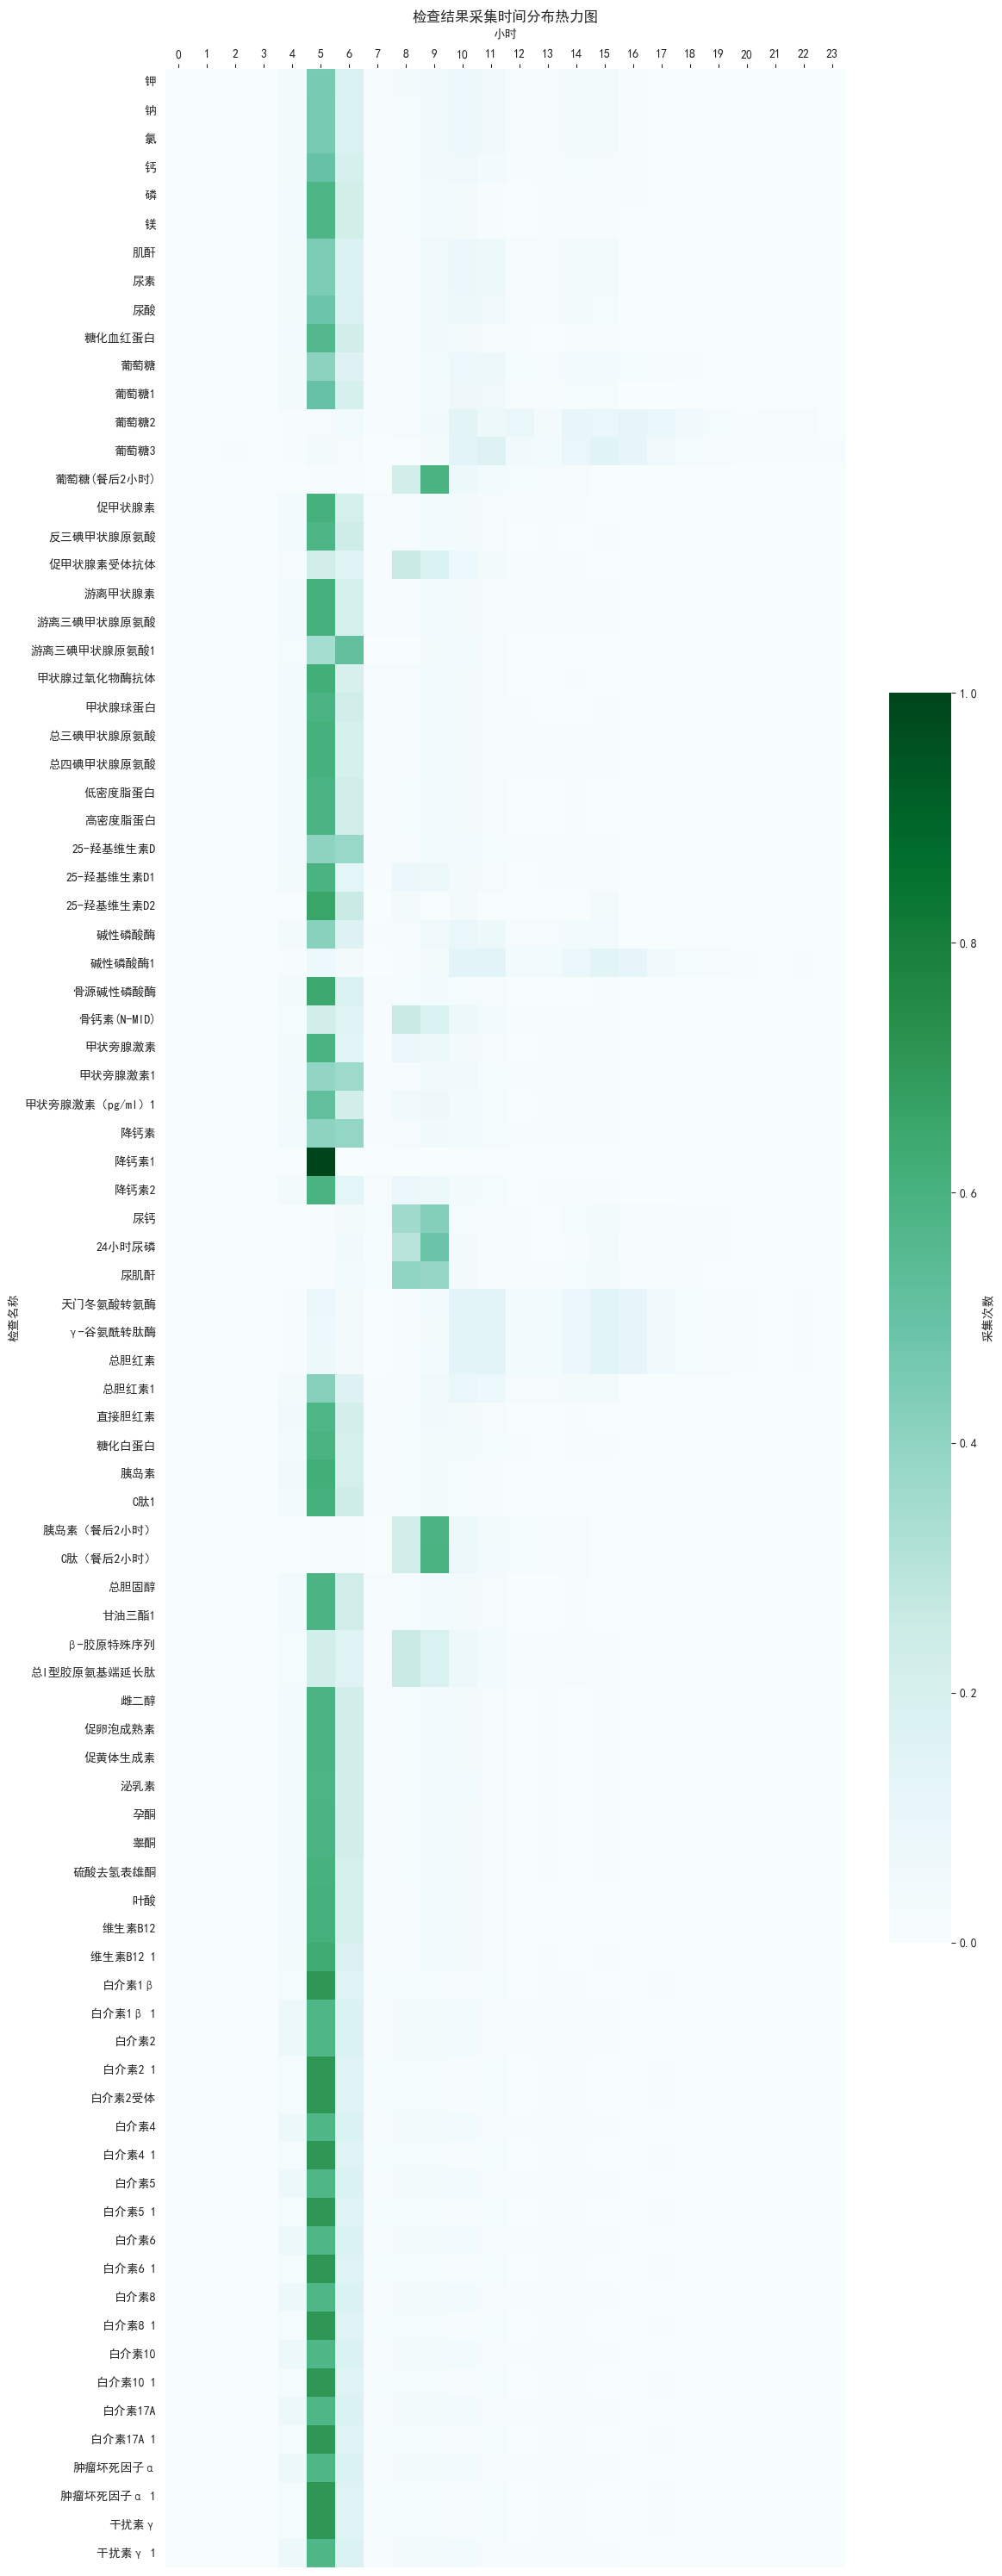

In [35]:
import seaborn as sns

df = df_backup.copy()

columns_to_analyze = df.columns[8:]
df['采集小时'] = pd.to_datetime(df['采集时间']).dt.hour
# 选择需要分析的检查名称列

# 创建一个矩阵，行是检查名称，列是小时，值是每小时的采集次数
heatmap_data = pd.DataFrame(0.0, index=columns_to_analyze, columns=range(24))

for col in columns_to_analyze:
    if col in df.columns:
        hour_counts = df.loc[df[col].notnull(), '采集小时'].value_counts()
        total_counts = hour_counts.sum()
        for hour, count in hour_counts.items():
            heatmap_data.loc[col, hour] = count
            heatmap_data.loc[col, hour] = heatmap_data.loc[col, hour] / total_counts # 若要计算占比

# 绘制热力图
plt.figure(figsize=(12, 30))  # 调整图形大小以适应检查名称
# 特意绘制成 Github commit cnt 的颜色
sns.heatmap(heatmap_data, annot=False, fmt='d', cmap='BuGn', cbar_kws={'label': '采集次数', 'shrink': 0.5},
            linewidths=0, linecolor='black', square=False)
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.xlabel('小时', labelpad=10)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.ylabel('检查名称')
plt.title('检查结果采集时间分布热力图')
plt.tight_layout()
plt.show()

我们大致能够看出以下的pattern：
- 绝大部分采集发生在清晨5\~7点之间。
- 标注为“餐后2h”的数据项多在9点多采集。
- 仔细观察浅色的色块，部分数据展现出了“一日三次”的规律。例如葡萄糖的三次采样可能在5时、11时、15时。